In [1]:
from multiprocessing import Pool, cpu_count
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import ticker as mticker
import seaborn as sns
import numpy as np

from timescales.conversions import convert_knee

# 06. Method Comparison

This notebook compares three Python packages for quantifing timescales: 1) aABC, 2) MR esimator, and 3) AR models.

## Simulations

1000 simulations where ran, with knees drawn from a random normal around 20 Hz.

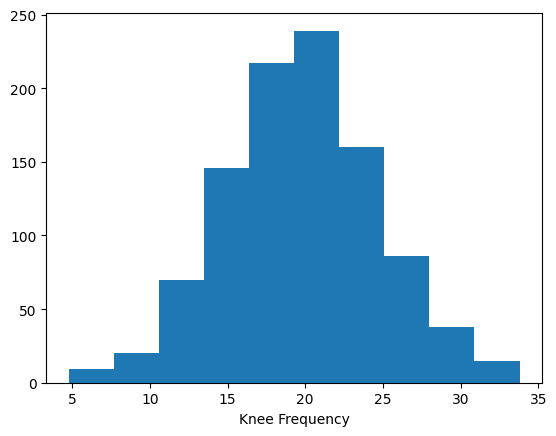

In [2]:
n_sims = 1000
np.random.seed(0)
knees_true = np.random.normal(20, 5, n_sims)

plt.hist(knees_true)
plt.xlabel('Knee Frequency');

In [3]:
from fig06 import compute_taus

with Pool(processes=10) as pool:
    mapping = pool.imap(compute_taus, knees_true)
    results = list(tqdm(mapping, total=len(knees_true)))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [4]:
# Save results
np.save('results.npy', np.array(results))

# Unpack results
knees_ar = np.array([i[0] for i in results])
knees_mr = np.array([i[1] for i in results])
knees_abc = np.array([i[2] for i in results])

times_ar = np.array([i[3] for i in results])
times_mr = np.array([i[4] for i in results])
times_abc = np.array([i[5] for i in results])

## Accuracy

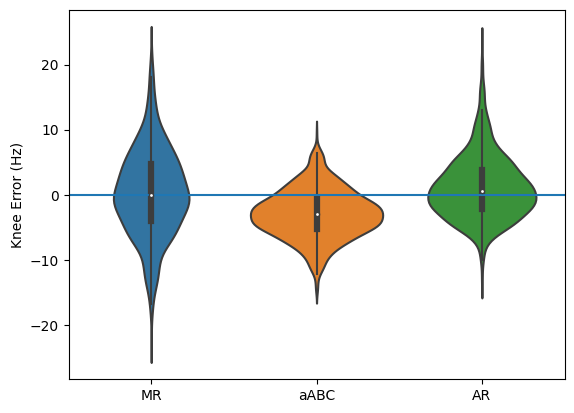

In [6]:
# Plot knees
sns.violinplot([k - knees_true for k in [knees_mr, knees_abc, knees_ar]])
plt.axhline(0)
plt.xticks([0, 1, 2], ['MR', 'aABC', 'AR'])
plt.ylabel('Knee Error (Hz)');

MR
Error Mean :  1.3854193798184493
Error Std. :  6.249124231873533

aABC
Error Mean :  2.3113362607205707
Error Std. :  4.158297287586033

AR
Error Mean :  -0.08939790599647231
Error Std. :  2.091549420555147



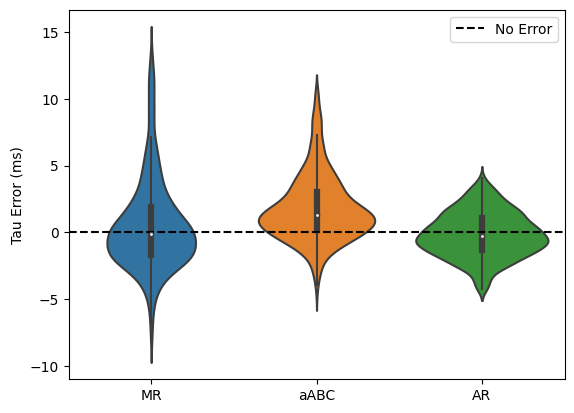

In [40]:
# Plot taus
tau_error = []
for k, l in zip([knees_mr, knees_abc, knees_ar], ['MR', 'aABC', 'AR']):
    
    _tau_error = (convert_knee(k)*1000) - (convert_knee(knees_true)*1000)
    
    print(l)
    print('Error Mean : ', _tau_error.mean())
    print('Error Std. : ', _tau_error.std())
    print()
    
    # drop outliers
    _tau_error = _tau_error[np.where(
        (_tau_error < _tau_error.mean() + 2 * _tau_error.std()) & 
        (_tau_error > _tau_error.mean() - 2 * _tau_error.std())
    )[0]]
    
    tau_error.append(_tau_error)

sns.violinplot(tau_error, showfliers=False)
plt.axhline(0, ls='--', color='k', label='No Error')
plt.legend()
plt.ylabel('Tau Error (ms)')
plt.xticks([0, 1, 2], ['MR', 'aABC', 'AR']);
plt.savefig('tau_error.png', dpi=300);

## Compute time

MR
Time Mean :  4.86698055267334
Time Std. :  14.205457745189323

aABC
Time Mean :  11938.115100860596
Time Std. :  1902.1355746072832

AR
Time Mean :  5.614748954772949
Time Std. :  2.9471337811852605



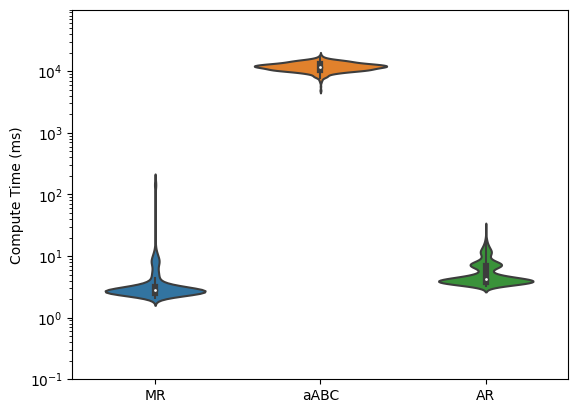

In [41]:
time = []

for t, l in zip([times_mr, times_abc, times_ar], ['MR', 'aABC', 'AR']):
    
    print(l)
    print('Time Mean : ', (t*1000).mean())
    print('Time Std. : ', (t*1000).std())
    print()
    
    time.append(t * 1000)
    

log_data = [[np.log10(d) for d in row] for row in time]
fig, ax = plt.subplots()
sns.violinplot(data=log_data, ax=ax)
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
ymin, ymax = ax.get_ylim()
tick_range = np.arange(np.floor(ymin), ymax)
ax.yaxis.set_ticks(tick_range)
ax.yaxis.set_ticks([np.log10(x) for p in tick_range
                    for x in np.linspace(10 ** p, 10 ** (p + 1), 10)], minor=True)
plt.ylabel('Compute Time (ms)');
plt.xticks([0, 1, 2], ['MR', 'aABC', 'AR']);
plt.savefig('time.png', dpi=300);